# Project code

gg

In [150]:
import os
from pathlib import Path
import time

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import v2

def tic():
    return time.time()
def toc(tstart, name="Operation", printtime=True):
    dt = time.time() - tstart
    if printtime:
        print("%s took: %s sec.\n" % (name, dt))
    return dt

## Data loading utilities

In [3]:
class CharDataset(Dataset):
    """
    General dataset for single character data loading.

    Assumes that in the directory given, the subdirectories are the classes.
    These directory names should be the single character class.
    """
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        if not self.img_dir.exists():
            raise FileNotFoundError(f"{img_dir} does not exist")
        alldirs = [p for p in self.img_dir.glob("*") if p.is_dir()]
        self.imgpaths = []
        self.imglabels = []
        for d in alldirs:
            chclass = d.stem.lower()
            imgpaths_dirty = list(d.glob("*.jpg")) + list(d.glob("*.png"))
            imgpaths = []
            for i in range(len(imgpaths_dirty)):
                try:
                    Image.open(imgpaths_dirty[i])
                except UnidentifiedImageError:
                    print(f"Image {imgpaths_dirty[i]} is not a valid image, skipping")
                    continue
                imgpaths.append(imgpaths_dirty[i])
            self.imgpaths.extend(imgpaths)
            self.imglabels.extend([chclass] * len(imgpaths))
        self.transform = transform

    def __len__(self):
        return len(self.imglabels)

    def __getitem__(self, idx):
        imgpath = self.imgpaths[idx]
        img = Image.open(imgpath).convert("L")
        label = self.imglabels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
def ds_to_vectors(ds, size=28):
    imgs = np.array([np.array(x[0].resize((28, 28))).reshape(-1) for x in ds])
    labs = np.array([x[1] for x in ds])
    return imgs, labs

In [4]:
randomrot_T = v2.Compose([
    v2.PILToTensor(),
    v2.RandomRotation(45),
    v2.ToPILImage()
])

In [62]:
# this dataset is already random rotated
handiso_ds_train = CharDataset("data/handwritten-isolated-english/train")
handiso_ds_test = CharDataset("data/handwritten-isolated-english/test")
handiso_test_data, handiso_test_labels = ds_to_vectors(handiso_ds_test)

notmnist_ds = CharDataset("data/notMNIST_small", transform=randomrot_T)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])
notmnist_test_data, notmnist_test_labels = ds_to_vectors(notmnist_ds_test)

stdocr_ds_train = CharDataset("data/standard_ocr_dataset/data/training_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/training_data", transform=randomrot_T)
stdocr_ds_test = CharDataset("data/standard_ocr_dataset/data/testing_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=randomrot_T)
stdocr_test_data, stdocr_test_labels = ds_to_vectors(stdocr_ds_test)

mnist_ds_train = MNIST(Path(os.getcwd(), "data"), train=True, transform=randomrot_T, target_transform=str)
mnist_ds_test = MNIST(Path(os.getcwd(), "data"), train=False, transform=randomrot_T, target_transform=str)
mnist_test_data, mnist_test_labels = ds_to_vectors(mnist_ds_test)

Image data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is not a valid image, skipping
Image data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is not a valid image, skipping
Image data/standard_ocr_dataset/data2/testing_data/G/44404.png is not a valid image, skipping


In [63]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train)}, test:{len(stdocr_ds_test)}]")
print(f"MNIST sizes: [train:{len(mnist_ds_train)}, test:{len(mnist_ds_test)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:41256, test:4249]
MNIST sizes: [train:60000, test:10000]


In [64]:
consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
cons_train_data, cons_train_labels = ds_to_vectors(consolidated_ds_train)
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test
cons_test_data, cons_test_labels = ds_to_vectors(consolidated_ds_test)

## Utility functions for model setup and testing

In [165]:
def run_all_tests_model(model, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    handwrscore = model.score(data_transform(handiso_test_data), handiso_test_labels)
    notmnistscore = model.score(data_transform(notmnist_test_data), notmnist_test_labels)
    stdocrscore = model.score(data_transform(stdocr_test_data), stdocr_test_labels)
    mnistscore = model.score(data_transform(mnist_test_data), mnist_test_labels)
    toc(ts, "Model testing")
    tot_test = len(handiso_test_labels) + len(notmnist_test_labels) + len(stdocr_test_labels) + len(mnist_test_labels)
    weighted_score = (handwrscore * len(handiso_test_labels) + notmnistscore * len(notmnist_test_labels) + stdocrscore * len(stdocr_test_labels) + mnistscore * len(mnist_test_labels)) / tot_test
    print(f"handwritten-isolated score: {handwrscore}\n"
          f"notMNIST score: {notmnistscore}\n"
          f"standard OCR score: {stdocrscore}\n"
          f"MNIST score: {mnistscore}\n"
          f"Aggregate score: {weighted_score}")
    return handwrscore, notmnistscore, stdocrscore, mnistscore, weighted_score

def test_trf_models(create_model_func, trf_funcs, mincomps, maxcomps):
    """
    create_model_func: (X, y, data_transform=func) -> scipy classification model
    """
    assert len(trf_funcs) == (maxcomps + 1) - mincomps
    handwrscores, notmnistscores, stdocrscores, mnistscores, aggscores = [], [], [], [], []
    traintimes, predicttimes = [], []
    for ncomp in range(mincomps, maxcomps + 1):
        print(f"n_components: {ncomp}")
        trf = trf_funcs[ncomp - mincomps]
        ts = tic()
        consol_model = create_model_func(cons_train_data, cons_train_labels, data_transform=trf)
        traintimes.append(toc(ts, printtime=False))
        ts = tic()
        handwrscore, notmnistscore, stdocrscore, mnistscore, aggscore = run_all_tests_model(consol_model, data_transform=trf)
        predicttimes.append(toc(ts, printtime=False))
        handwrscores.append(handwrscore)
        notmnistscores.append(notmnistscore)
        stdocrscores.append(stdocrscore)
        mnistscores.append(mnistscore)
        aggscores.append(aggscore)
        print("------")
    return {
        "handwrscores": handwrscores,
        "notmnistscores": notmnistscores,
        "stdocrscores": stdocrscores,
        "mnistscores": mnistscores,
        "aggscores": aggscores,
        "traintimes": traintimes,
        "predicttimes": predicttimes
    }

def plot_scores(results, ncomplist, title="Classification results for dimensionality reduction"):
    fig, ax = plt.subplots()
    ax.plot(ncomplist, results["handwrscores"], label="handwritten-isolated")
    ax.plot(ncomplist, results["notmnistscores"], label="notMNIST")
    ax.plot(ncomplist, results["stdocrscores"], label="standard OCR")
    ax.plot(ncomplist, results["mnistscores"], label="MNIST")
    ax.plot(ncomplist, results["aggscores"], label="aggregated")
    ax.set_xlabel("number of components")
    ax.set_ylabel("test accuracy")
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [105]:
def create_logreg(X, y, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    logreg = LogisticRegression()
    logreg.fit(data_transform(X), y)
    toc(ts, "Logistic Regression training")
    return logreg

def create_knn(X, y, k=5, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_transform(X), y)
    toc(ts, "KNN training")
    return knn

## Raw model tests

In [121]:
# logistic regression linear classifier
consol_logreg = create_logreg(cons_train_data, cons_train_labels)
run_all_tests_model(consol_logreg)

Logistic Regression training took: 53.39464592933655 sec.

Model testing took: 0.08474993705749512 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.3557692307692308
standard OCR score: 0.4238644386914568
MNIST score: 0.7246
Aggregate score: 0.5283295425827648


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.041294642857142856,
 0.3557692307692308,
 0.4238644386914568,
 0.7246,
 0.5283295425827648)

In [122]:
# KNN classifier
consol_knn = create_knn(cons_train_data, cons_train_labels, k=5)
run_all_tests_model(consol_knn)

KNN training took: 0.010005950927734375 sec.

Model testing took: 41.989635944366455 sec.

handwritten-isolated score: 0.6032366071428571
notMNIST score: 0.7753739316239316
standard OCR score: 0.9042127559425748
MNIST score: 0.9396
Aggregate score: 0.8704574172352793


(0.6032366071428571,
 0.7753739316239316,
 0.9042127559425748,
 0.9396,
 0.8704574172352793)

## Tests with PCA

In [98]:
def create_pca(X, n_components):
    ts = tic()
    pca = PCA(n_components=n_components)
    pca.fit(X)
    toc(ts, "Creating PCA components")
    return pca

# could probably just initialize PCA with max components first, then just subset the
# eigenvectors, but I'm too lazy to do that
allpcas = [create_pca(cons_train_data, i) for i in range(2, 60)]
pcatrf_funcs = [pca.transform for pca in allpcas]

Creating PCA components took: 1.9968338012695312 sec.

Creating PCA components took: 1.890021800994873 sec.

Creating PCA components took: 1.8968229293823242 sec.

Creating PCA components took: 1.9786338806152344 sec.

Creating PCA components took: 2.664804220199585 sec.

Creating PCA components took: 2.125735282897949 sec.

Creating PCA components took: 3.256588935852051 sec.

Creating PCA components took: 2.7942771911621094 sec.

Creating PCA components took: 4.283822059631348 sec.

Creating PCA components took: 6.167045831680298 sec.

Creating PCA components took: 5.372321605682373 sec.

Creating PCA components took: 5.275005102157593 sec.

Creating PCA components took: 4.796183109283447 sec.

Creating PCA components took: 3.71964693069458 sec.

Creating PCA components took: 4.492445230484009 sec.

Creating PCA components took: 5.078211069107056 sec.

Creating PCA components took: 4.635692834854126 sec.

Creating PCA components took: 4.589389085769653 sec.

Creating PCA components t

In [131]:
pcatrf_funcs = [pca.transform for pca in allpcas]

### Logistic regression linear classifier

In [135]:
logreg_pca_results = test_trf_models(create_logreg, pcatrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.963161945343018 sec.

Model testing took: 0.06705093383789062 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.08199786324786325
standard OCR score: 0.02706519180983761
MNIST score: 0.2195
Aggregate score: 0.13560778367450088
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.172131776809692 sec.

Model testing took: 0.07590794563293457 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.07799145299145299
standard OCR score: 0.01906330901388562
MNIST score: 0.2847
Aggregate score: 0.16563052817791257
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.414907932281494 sec.

Model testing took: 0.05923199653625488 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.0798611111111111
standard OCR score: 0.02353494939985879
MNIST score: 0.3003
Aggregate score: 0.17498104624715694
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.947263956069946 sec.

Model testing took: 0.09344196319580078 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.09695512820512821
standard OCR score: 0.03271357966580372
MNIST score: 0.3523
Aggregate score: 0.20652009097801366
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.339582920074463 sec.

Model testing took: 0.0672452449798584 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.11057692307692307
standard OCR score: 0.051070840197693576
MNIST score: 0.369
Aggregate score: 0.221986353297953
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.948161602020264 sec.

Model testing took: 0.06605315208435059 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.12126068376068376
standard OCR score: 0.057660626029654036
MNIST score: 0.3824
Aggregate score: 0.2313874147081122
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.657893896102905 sec.

Model testing took: 0.06855297088623047 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.13835470085470086
standard OCR score: 0.0661332078136032
MNIST score: 0.3944
Aggregate score: 0.24306292645943897
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.150116205215454 sec.

Model testing took: 0.04785776138305664 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.1936431623931624
standard OCR score: 0.08802071075547188
MNIST score: 0.4013
Aggregate score: 0.26161233257518324
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.5612781047821045 sec.

Model testing took: 0.06033587455749512 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.19951923076923078
standard OCR score: 0.12144033890327136
MNIST score: 0.4171
Aggregate score: 0.2774323982815264
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.575042963027954 sec.

Model testing took: 0.06673884391784668 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.21634615384615385
standard OCR score: 0.13297246410920216
MNIST score: 0.4904
Aggregate score: 0.3203942380591357
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.746344327926636 sec.

Model testing took: 0.0749979019165039 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.22115384615384615
standard OCR score: 0.15697811249705812
MNIST score: 0.5456
Aggregate score: 0.3543593631539045
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.5652830600738525 sec.

Model testing took: 0.0825662612915039 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.2329059829059829
standard OCR score: 0.16898093669098613
MNIST score: 0.5803
Aggregate score: 0.37725549658832447
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.998532056808472 sec.

Model testing took: 0.06428074836730957 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.24866452991452992
standard OCR score: 0.17227582960696636
MNIST score: 0.5881
Aggregate score: 0.38458428102097547
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.154567003250122 sec.

Model testing took: 0.06107902526855469 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.2761752136752137
standard OCR score: 0.17439397505295365
MNIST score: 0.619
Aggregate score: 0.40636846095526913
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.959928035736084 sec.

Model testing took: 0.06614303588867188 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.2692307692307692
standard OCR score: 0.18451400329489293
MNIST score: 0.625
Aggregate score: 0.4101086681829669
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.151173114776611 sec.

Model testing took: 0.08215022087097168 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.26495726495726496
standard OCR score: 0.18992704165686045
MNIST score: 0.6548
Aggregate score: 0.42527167045741726
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.6136839389801025 sec.

Model testing took: 0.0546112060546875 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.2761752136752137
standard OCR score: 0.20334196281477995
MNIST score: 0.655
Aggregate score: 0.430224917867071
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.93871283531189 sec.

Model testing took: 0.05884885787963867 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.27564102564102566
standard OCR score: 0.21087314662273476
MNIST score: 0.6641
Aggregate score: 0.436340662117766
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.524693012237549 sec.

Model testing took: 0.08168792724609375 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.27377136752136755
standard OCR score: 0.23582019298658508
MNIST score: 0.6678
Aggregate score: 0.44316401314126863
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.285567045211792 sec.

Model testing took: 0.0675809383392334 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28392094017094016
standard OCR score: 0.2511179100964933
MNIST score: 0.6684
Aggregate score: 0.44872378064190044
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.78131890296936 sec.

Model testing took: 0.07474017143249512 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28552350427350426
standard OCR score: 0.2584137444104495
MNIST score: 0.6696
Aggregate score: 0.4512004043467273
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.82523512840271 sec.

Model testing took: 0.08218598365783691 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2849893162393162
standard OCR score: 0.26947517062838316
MNIST score: 0.6716
Aggregate score: 0.45428354814253225
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.311882019042969 sec.

Model testing took: 0.09627914428710938 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28899572649572647
standard OCR score: 0.2647681807484114
MNIST score: 0.6765
Aggregate score: 0.45670962850644425
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.337680101394653 sec.

Model testing took: 0.06155705451965332 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.2919337606837607
standard OCR score: 0.26194398682042835
MNIST score: 0.6784
Aggregate score: 0.4579732120293151
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.511757135391235 sec.

Model testing took: 0.10211420059204102 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.2916666666666667
standard OCR score: 0.2666509767004001
MNIST score: 0.6748
Aggregate score: 0.4570634318928481
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.868198871612549 sec.

Model testing took: 0.09087586402893066 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.28872863247863245
standard OCR score: 0.2727700635443634
MNIST score: 0.6772
Aggregate score: 0.45898407884761183
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.712373971939087 sec.

Model testing took: 0.09750103950500488 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.2841880341880342
standard OCR score: 0.27912449988232524
MNIST score: 0.6827
Aggregate score: 0.4619661359615871
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.359468936920166 sec.

Model testing took: 0.07552909851074219 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.2831196581196581
standard OCR score: 0.2833607907742998
MNIST score: 0.6825
Aggregate score: 0.46287591609805406
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.247149229049683 sec.

Model testing took: 0.0721588134765625 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.2857905982905983
standard OCR score: 0.28547893622028714
MNIST score: 0.6825
Aggregate score: 0.46383623957543596
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.9495530128479 sec.

Model testing took: 0.12662720680236816 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.2847222222222222
standard OCR score: 0.28900917863026593
MNIST score: 0.6824
Aggregate score: 0.46383623957543596
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.933415174484253 sec.

Model testing took: 0.08116698265075684 sec.

handwritten-isolated score: 0.03125
notMNIST score: 0.28739316239316237
standard OCR score: 0.2901859261002589
MNIST score: 0.6818
Aggregate score: 0.46413949962092493
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.522022008895874 sec.

Model testing took: 0.14056611061096191 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2863247863247863
standard OCR score: 0.29536361496822783
MNIST score: 0.6836
Aggregate score: 0.46606014657568867
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.18676209449768 sec.

Model testing took: 0.07490301132202148 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.28846153846153844
standard OCR score: 0.29795245940221227
MNIST score: 0.6869
Aggregate score: 0.4687894869850897
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 15.508172035217285 sec.

Model testing took: 0.0808250904083252 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.2876602564102564
standard OCR score: 0.30171805130618967
MNIST score: 0.689
Aggregate score: 0.47060904725802377
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.559890031814575 sec.

Model testing took: 0.07733821868896484 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.28739316239316237
standard OCR score: 0.30242409978818546
MNIST score: 0.6882
Aggregate score: 0.47015415718979026
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.40687108039856 sec.

Model testing took: 0.07412099838256836 sec.

handwritten-isolated score: 0.030133928571428572
notMNIST score: 0.2831196581196581
standard OCR score: 0.30830783713815013
MNIST score: 0.6891
Aggregate score: 0.47081122062168307
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.98393201828003 sec.

Model testing took: 0.07159113883972168 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.28365384615384615
standard OCR score: 0.3099552835961403
MNIST score: 0.691
Aggregate score: 0.4722769775082133
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.393671989440918 sec.

Model testing took: 0.07001590728759766 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.28952991452991456
standard OCR score: 0.311838079548129
MNIST score: 0.6933
Aggregate score: 0.475107404599444
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.261216878890991 sec.

Model testing took: 0.1147909164428711 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2857905982905983
standard OCR score: 0.31348552600611906
MNIST score: 0.6918
Aggregate score: 0.47409653778114735
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.823508024215698 sec.

Model testing took: 0.10237312316894531 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2903311965811966
standard OCR score: 0.31772181689809365
MNIST score: 0.694
Aggregate score: 0.47687642153146326
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.413052797317505 sec.

Model testing took: 0.11049818992614746 sec.

handwritten-isolated score: 0.03125
notMNIST score: 0.2881944444444444
standard OCR score: 0.3205460108260767
MNIST score: 0.6905
Aggregate score: 0.4752084912812737
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.51163387298584 sec.

Model testing took: 0.09180092811584473 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.2919337606837607
standard OCR score: 0.3212520593080725
MNIST score: 0.6925
Aggregate score: 0.47702805155420774
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.679504871368408 sec.

Model testing took: 0.07144689559936523 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2932692307692308
standard OCR score: 0.3205460108260767
MNIST score: 0.6943
Aggregate score: 0.47819054839524894
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.452602863311768 sec.

Model testing took: 0.11337423324584961 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2951388888888889
standard OCR score: 0.32172275829606967
MNIST score: 0.6968
Aggregate score: 0.4800606520090978
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.169703960418701 sec.

Model testing took: 0.0818018913269043 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.2954059829059829
standard OCR score: 0.3210167098140739
MNIST score: 0.6957
Aggregate score: 0.4796563052817791
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.577071905136108 sec.

Model testing took: 0.11238884925842285 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.2938034188034188
standard OCR score: 0.3247823017180513
MNIST score: 0.6948
Aggregate score: 0.47930250189537527
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.119888067245483 sec.

Model testing took: 0.09502100944519043 sec.

handwritten-isolated score: 0.029575892857142856
notMNIST score: 0.2951388888888889
standard OCR score: 0.3273711461520358
MNIST score: 0.6975
Aggregate score: 0.4813747788728835
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.691397666931152 sec.

Model testing took: 0.08690023422241211 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.296741452991453
standard OCR score: 0.33325488350200044
MNIST score: 0.6991
Aggregate score: 0.48385140257771037
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.874680757522583 sec.

Model testing took: 0.07823491096496582 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.3002136752136752
standard OCR score: 0.3351376794539892
MNIST score: 0.6996
Aggregate score: 0.4851655294414961
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.183156967163086 sec.

Model testing took: 0.1513810157775879 sec.

handwritten-isolated score: 0.029575892857142856
notMNIST score: 0.2980769230769231
standard OCR score: 0.3287832431160273
MNIST score: 0.7004
Aggregate score: 0.4836997725549659
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.624950885772705 sec.

Model testing took: 0.08302092552185059 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.29967948717948717
standard OCR score: 0.33090138856201456
MNIST score: 0.6996
Aggregate score: 0.48425574930502907
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.064424991607666 sec.

Model testing took: 0.0746610164642334 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2986111111111111
standard OCR score: 0.33537302894798776
MNIST score: 0.7011
Aggregate score: 0.4859236795552186
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.512369871139526 sec.

Model testing took: 0.07799673080444336 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.29967948717948717
standard OCR score: 0.3374911743939751
MNIST score: 0.7007
Aggregate score: 0.4863785696234521
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.775155782699585 sec.

Model testing took: 0.09469103813171387 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.29967948717948717
standard OCR score: 0.33796187338197226
MNIST score: 0.701
Aggregate score: 0.48658074298711146
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.911525249481201 sec.

Model testing took: 0.09098601341247559 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.2988782051282051
standard OCR score: 0.3370204754059779
MNIST score: 0.7021
Aggregate score: 0.4869345463735153
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.874300718307495 sec.

Model testing took: 0.12833809852600098 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.2983440170940171
standard OCR score: 0.34102141680395387
MNIST score: 0.7048
Aggregate score: 0.4890068233510235
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.179108142852783 sec.

Model testing took: 0.07980608940124512 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.29407051282051283
standard OCR score: 0.3431395622499412
MNIST score: 0.7053
Aggregate score: 0.48895628001010866
------
n_components: 59
Logistic Regression training took: 12.419043064117432 sec.

Model testing took: 0.0943901538848877 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2951388888888889
standard OCR score: 0.3438456107319369
MNIST score: 0.7059
Aggregate score: 0.48951225676017185
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


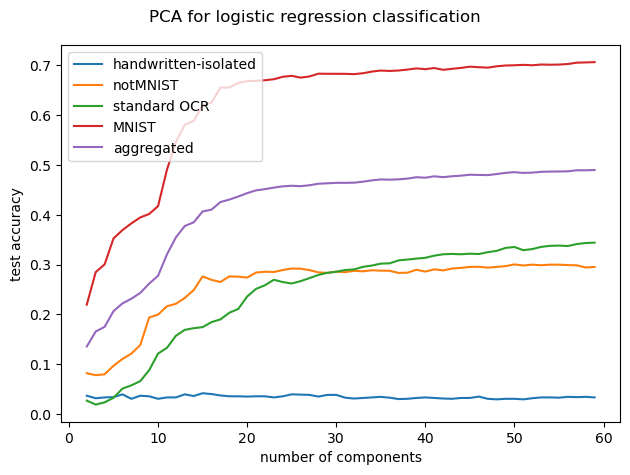

In [171]:
plot_scores(logreg_pca_results, range(2, 60), title="PCA for logistic regression classification")

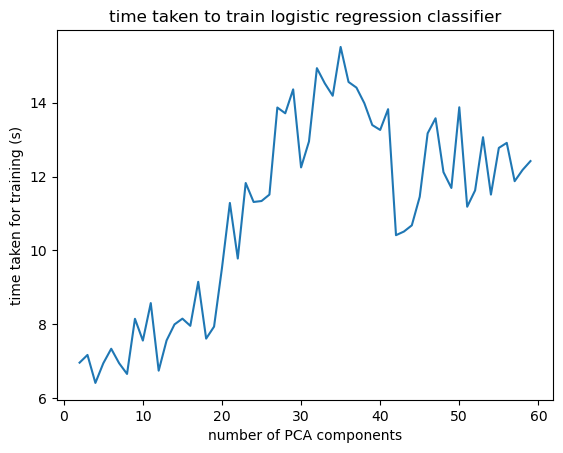

In [141]:
plt.plot(range(2, 60), logreg_pca_results["traintimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for training (s)")
plt.title("time taken to train logistic regression classifier")
plt.show()

### KNN classifier

In [143]:
knn_pca_results = test_trf_models(create_knn, pcatrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.5073657035827637 sec.

Model testing took: 0.3257169723510742 sec.

handwritten-isolated score: 0.28404017857142855
notMNIST score: 0.17387820512820512
standard OCR score: 0.06942810072958343
MNIST score: 0.2322
Aggregate score: 0.19090219863532978
------
n_components: 3
KNN training took: 0.37589406967163086 sec.

Model testing took: 0.3265371322631836 sec.

handwritten-isolated score: 0.31473214285714285
notMNIST score: 0.2676282051282051
standard OCR score: 0.1052012238173688
MNIST score: 0.3062
Aggregate score: 0.25650745514278495
------
n_components: 4
KNN training took: 0.3249049186706543 sec.

Model testing took: 0.36452317237854004 sec.

handwritten-isolated score: 0.34375
notMNIST score: 0.36538461538461536
standard OCR score: 0.19581077900682514
MNIST score: 0.3778
Aggregate score: 0.3332827899924185
------
n_components: 5
KNN training took: 0.3466501235961914 sec.

Model testing took: 0.42598605155944824 sec.

handwritten-isolated score: 

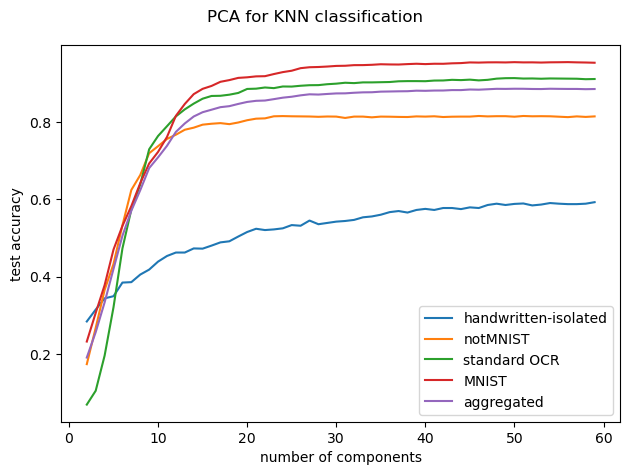

In [170]:
plot_scores(knn_pca_results, range(2, 60), title="PCA for KNN classification")

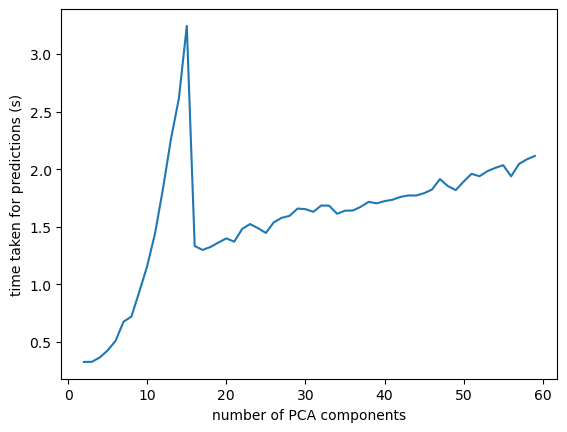

In [145]:
plt.plot(range(2, 60), knn_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.show()

## Tests with LDA

In [130]:
def create_lda(X, y, n_components):
    ts = tic()
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    toc(ts, "Creating LDA components")
    return lda
allldas = [create_lda(cons_train_data, cons_train_labels, i) for i in range(1, 35)]
ldatrf_funcs = [lda.transform for lda in allldas]

Creating LDA components took: 13.346649885177612 sec.

Creating LDA components took: 14.741846084594727 sec.

Creating LDA components took: 12.922446012496948 sec.

Creating LDA components took: 12.10661506652832 sec.

Creating LDA components took: 11.00128698348999 sec.

Creating LDA components took: 11.540860176086426 sec.

Creating LDA components took: 11.732718229293823 sec.

Creating LDA components took: 11.68259882926941 sec.

Creating LDA components took: 13.502244710922241 sec.

Creating LDA components took: 11.3767671585083 sec.

Creating LDA components took: 12.66239309310913 sec.

Creating LDA components took: 15.829773902893066 sec.

Creating LDA components took: 12.754503965377808 sec.

Creating LDA components took: 12.821377038955688 sec.

Creating LDA components took: 15.03078293800354 sec.

Creating LDA components took: 11.985990047454834 sec.

Creating LDA components took: 12.226351261138916 sec.

Creating LDA components took: 12.016690254211426 sec.

Creating LDA comp

In [139]:
ldatrf_funcs = [lda.transform for lda in allldas]

### Logistic regression linear classifier

In [146]:
logreg_lda_results = test_trf_models(create_logreg, ldatrf_funcs, 1, 34)

n_components: 1
Logistic Regression training took: 1.629500389099121 sec.

Model testing took: 0.11202788352966309 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.07932692307692307
standard OCR score: 0.036243822075782535
MNIST score: 0.1808
Aggregate score: 0.1174627242860753
------
n_components: 2
Logistic Regression training took: 3.133561134338379 sec.

Model testing took: 0.11924409866333008 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.05181623931623932
standard OCR score: 0.04824664626971052
MNIST score: 0.3707
Aggregate score: 0.21076573161485973
------
n_components: 3
Logistic Regression training took: 2.588895082473755 sec.

Model testing took: 0.07788538932800293 sec.

handwritten-isolated score: 0.026227678571428572
notMNIST score: 0.040331196581196584
standard OCR score: 0.09719934102141681
MNIST score: 0.4682
Aggregate score: 0.26752590346221883
------
n_components: 4
Logistic Regression training took: 2.6398561000823975 s

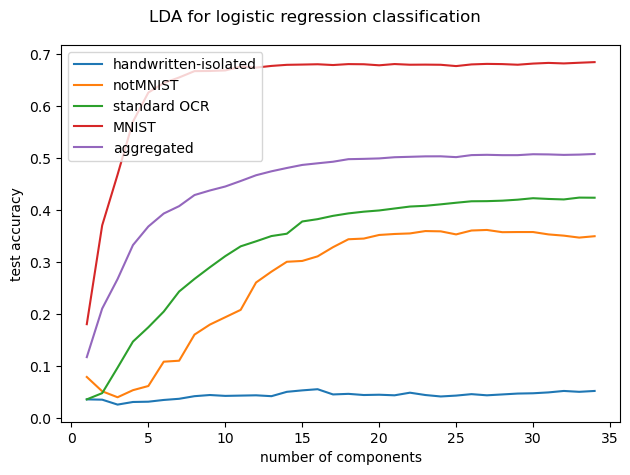

In [169]:
plot_scores(logreg_lda_results, range(1, 35), title="LDA for logistic regression classification")

### KNN classifier

In [148]:
knn_lda_results = test_trf_models(create_knn, ldatrf_funcs, 1, 34)

n_components: 1
KNN training took: 0.32746386528015137 sec.

Model testing took: 0.3150289058685303 sec.

handwritten-isolated score: 0.22991071428571427
notMNIST score: 0.07158119658119658
standard OCR score: 0.035302424099788184
MNIST score: 0.1717
Aggregate score: 0.1287338893100834
------
n_components: 2
KNN training took: 0.2997589111328125 sec.

Model testing took: 0.3385920524597168 sec.

handwritten-isolated score: 0.24386160714285715
notMNIST score: 0.08733974358974358
standard OCR score: 0.05601317957166392
MNIST score: 0.3513
Aggregate score: 0.22820318423047764
------
n_components: 3
KNN training took: 0.3137691020965576 sec.

Model testing took: 0.3957200050354004 sec.

handwritten-isolated score: 0.3364955357142857
notMNIST score: 0.12446581196581197
standard OCR score: 0.12544128030124735
MNIST score: 0.4476
Aggregate score: 0.3072024260803639
------
n_components: 4
KNN training took: 0.3911428451538086 sec.

Model testing took: 0.4032599925994873 sec.

handwritten-isola

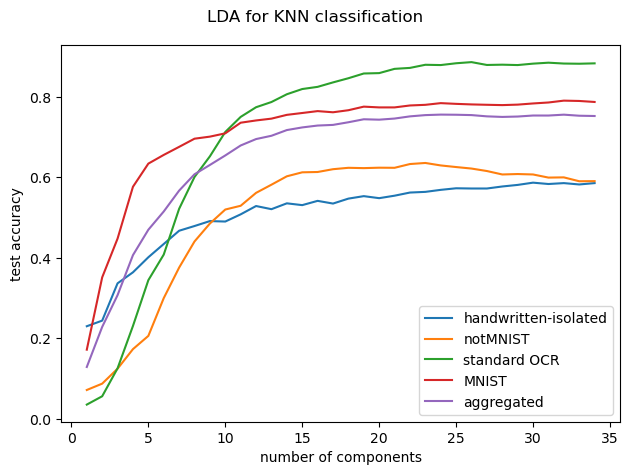

In [168]:
plot_scores(knn_lda_results, range(1, 35), title="LDA for KNN classification")

## Tests with random Gaussian projection

In [158]:
allgrps = [GaussianRandomProjection(n_components=i, random_state=1).fit(cons_train_data) for i in range(2, 60)]
rgptrf_funcs = [grp.transform for grp in allgrps]

### Logistic regression

In [159]:
logreg_rgp_results = test_trf_models(create_logreg, rgptrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.691750764846802 sec.

Model testing took: 0.05610513687133789 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.028579059829059828
standard OCR score: 0.03012473523181925
MNIST score: 0.1627
Aggregate score: 0.09704321455648218
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.281052827835083 sec.

Model testing took: 0.04659724235534668 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.028044871794871796
standard OCR score: 0.039538714991762765
MNIST score: 0.1798
Aggregate score: 0.10846600960323477
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.701736927032471 sec.

Model testing took: 0.040904998779296875 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.0827991452991453
standard OCR score: 0.03859731701576841
MNIST score: 0.2344
Aggregate score: 0.14607025524387163
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.9834160804748535 sec.

Model testing took: 0.0543360710144043 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.09428418803418803
standard OCR score: 0.040480112967757116
MNIST score: 0.2591
Aggregate score: 0.1612838008592368
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.982257127761841 sec.

Model testing took: 0.06028628349304199 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.07745726495726496
standard OCR score: 0.044716403859731704
MNIST score: 0.2885
Aggregate score: 0.17326257265605258
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.998031854629517 sec.

Model testing took: 0.039244890213012695 sec.

handwritten-isolated score: 0.05580357142857143
notMNIST score: 0.07692307692307693
standard OCR score: 0.04659919981172041
MNIST score: 0.2715
Aggregate score: 0.16684356835986858
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.84759783744812 sec.

Model testing took: 0.03226327896118164 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.10256410256410256
standard OCR score: 0.0506001412096964
MNIST score: 0.2639
Aggregate score: 0.1670962850644428
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.869050979614258 sec.

Model testing took: 0.030220985412597656 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.12793803418803418
standard OCR score: 0.0524829371616851
MNIST score: 0.2785
Aggregate score: 0.1798837503158959
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.19414496421814 sec.

Model testing took: 0.0393369197845459 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.1388888888888889
standard OCR score: 0.05954342198164274
MNIST score: 0.2921
Aggregate score: 0.19095274197624465
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.229989051818848 sec.

Model testing took: 0.036047935485839844 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.14903846153846154
standard OCR score: 0.05907272299364556
MNIST score: 0.3013
Aggregate score: 0.19777609299974727
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.384766101837158 sec.

Model testing took: 0.035936832427978516 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.15064102564102563
standard OCR score: 0.06283831489762297
MNIST score: 0.3119
Aggregate score: 0.20429618397776092
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.267178058624268 sec.

Model testing took: 0.03573203086853027 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.16319444444444445
standard OCR score: 0.0698987997175806
MNIST score: 0.3234
Aggregate score: 0.21400050543340915
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.417258977890015 sec.

Model testing took: 0.035684823989868164 sec.

handwritten-isolated score: 0.0546875
notMNIST score: 0.16159188034188035
standard OCR score: 0.06919275123558484
MNIST score: 0.3395
Aggregate score: 0.221986353297953
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.549731969833374 sec.

Model testing took: 0.03380918502807617 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.16693376068376067
standard OCR score: 0.07625323605554248
MNIST score: 0.3482
Aggregate score: 0.2287591609805408
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.7270588874816895 sec.

Model testing took: 0.03972220420837402 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.1674679487179487
standard OCR score: 0.07719463403153683
MNIST score: 0.362
Aggregate score: 0.23588577204953248
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.148303031921387 sec.

Model testing took: 0.04974007606506348 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.1655982905982906
standard OCR score: 0.08472581783949165
MNIST score: 0.3769
Aggregate score: 0.24447814000505433
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.462725877761841 sec.

Model testing took: 0.045918941497802734 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.18669871794871795
standard OCR score: 0.08307837138150152
MNIST score: 0.3862
Aggregate score: 0.25246398786959817
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.562679767608643 sec.

Model testing took: 0.04713606834411621 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.19177350427350429
standard OCR score: 0.09319839962344081
MNIST score: 0.4114
Aggregate score: 0.268081880212282
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.584191083908081 sec.

Model testing took: 0.10546493530273438 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.19604700854700854
standard OCR score: 0.09978818545540127
MNIST score: 0.4287
Aggregate score: 0.2796057619408643
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.592775821685791 sec.

Model testing took: 0.13391518592834473 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.20245726495726496
standard OCR score: 0.10261237938338433
MNIST score: 0.4358
Aggregate score: 0.2851149861005812
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.019098997116089 sec.

Model testing took: 0.054489850997924805 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.1952457264957265
standard OCR score: 0.11061426217933631
MNIST score: 0.4576
Aggregate score: 0.29623452110184484
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.522167205810547 sec.

Model testing took: 0.060044050216674805 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.2077991452991453
standard OCR score: 0.11885149446928689
MNIST score: 0.4603
Aggregate score: 0.30179428860247665
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.807348012924194 sec.

Model testing took: 0.058331966400146484 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.20112179487179488
standard OCR score: 0.124499882325253
MNIST score: 0.4647
Aggregate score: 0.30381602223907
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.039360046386719 sec.

Model testing took: 0.09823822975158691 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.19818376068376067
standard OCR score: 0.128500823723229
MNIST score: 0.4665
Aggregate score: 0.3055344958301744
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.587207078933716 sec.

Model testing took: 0.12662506103515625 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.202991452991453
standard OCR score: 0.13320781360320075
MNIST score: 0.4776
Aggregate score: 0.31271165024008085
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.262207984924316 sec.

Model testing took: 0.10099291801452637 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.20726495726495728
standard OCR score: 0.13579665803718521
MNIST score: 0.4906
Aggregate score: 0.32054586808188024
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.548205137252808 sec.

Model testing took: 0.08865809440612793 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.20592948717948717
standard OCR score: 0.14285714285714285
MNIST score: 0.4937
Aggregate score: 0.3236795552185999
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.18691873550415 sec.

Model testing took: 0.06527996063232422 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.20512820512820512
standard OCR score: 0.1477994822311132
MNIST score: 0.5086
Aggregate score: 0.331918119787718
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.588748931884766 sec.

Model testing took: 0.08465194702148438 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.2094017094017094
standard OCR score: 0.15015297717109907
MNIST score: 0.5131
Aggregate score: 0.3356077836745009
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.961741209030151 sec.

Model testing took: 0.0523381233215332 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.20966880341880342
standard OCR score: 0.15509531654506942
MNIST score: 0.5137
Aggregate score: 0.3371240839019459
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.201663970947266 sec.

Model testing took: 0.07131600379943848 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.2171474358974359
standard OCR score: 0.15674276300305953
MNIST score: 0.5283
Aggregate score: 0.34607025524387164
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.895890951156616 sec.

Model testing took: 0.05131983757019043 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.21955128205128205
standard OCR score: 0.16427394681101434
MNIST score: 0.5281
Aggregate score: 0.34768764215314635
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.23930811882019 sec.

Model testing took: 0.0603029727935791 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.2203525641025641
standard OCR score: 0.16356789832901858
MNIST score: 0.5322
Aggregate score: 0.34950720242608035
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.879510164260864 sec.

Model testing took: 0.06144094467163086 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.21634615384615385
standard OCR score: 0.1678041892209932
MNIST score: 0.5359
Aggregate score: 0.35173110942633307
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.632884979248047 sec.

Model testing took: 0.06408500671386719 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.2155448717948718
standard OCR score: 0.17039303365497765
MNIST score: 0.536
Aggregate score: 0.35228708617639626
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.63448691368103 sec.

Model testing took: 0.06764912605285645 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.21768162393162394
standard OCR score: 0.17062838314897624
MNIST score: 0.5381
Aggregate score: 0.3539550164265858
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.695642948150635 sec.

Model testing took: 0.04495692253112793 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.21901709401709402
standard OCR score: 0.17109908213697342
MNIST score: 0.5391
Aggregate score: 0.3550164265857973
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.50593614578247 sec.

Model testing took: 0.05253005027770996 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.22248931623931623
standard OCR score: 0.1732172275829607
MNIST score: 0.5473
Aggregate score: 0.3601213040181956
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.16717267036438 sec.

Model testing took: 0.06587386131286621 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.21848290598290598
standard OCR score: 0.17815956695693105
MNIST score: 0.5471
Aggregate score: 0.36087945413191813
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.480653047561646 sec.

Model testing took: 0.08779716491699219 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.21955128205128205
standard OCR score: 0.18357260531889857
MNIST score: 0.5515
Aggregate score: 0.364569118018701
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.782519102096558 sec.

Model testing took: 0.07879400253295898 sec.

handwritten-isolated score: 0.05189732142857143
notMNIST score: 0.21634615384615385
standard OCR score: 0.18639679924688163
MNIST score: 0.5548
Aggregate score: 0.36608541824614604
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.612786054611206 sec.

Model testing took: 0.07903265953063965 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.21901709401709402
standard OCR score: 0.19039774064485762
MNIST score: 0.5589
Aggregate score: 0.3693201920646954
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.886037826538086 sec.

Model testing took: 0.056497812271118164 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.22275641025641027
standard OCR score: 0.1948693810308308
MNIST score: 0.5631
Aggregate score: 0.3728582259287339
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.05382490158081 sec.

Model testing took: 0.06358718872070312 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.22275641025641027
standard OCR score: 0.1983996234408096
MNIST score: 0.5665
Aggregate score: 0.3753853929744756
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.32384705543518 sec.

Model testing took: 0.11496329307556152 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.2264957264957265
standard OCR score: 0.19698752647681808
MNIST score: 0.5668
Aggregate score: 0.37604245640636846
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 15.148314237594604 sec.

Model testing took: 0.09673285484313965 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.2248931623931624
standard OCR score: 0.20334196281477995
MNIST score: 0.5659
Aggregate score: 0.3762951731109426
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 18.090007066726685 sec.

Model testing took: 0.0928049087524414 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.22275641025641027
standard OCR score: 0.2064015062367616
MNIST score: 0.5663
Aggregate score: 0.376497346474602
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.039522647857666 sec.

Model testing took: 0.06125497817993164 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.22569444444444445
standard OCR score: 0.20969639915274182
MNIST score: 0.5714
Aggregate score: 0.3804902704068739
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.544825077056885 sec.

Model testing took: 0.10341596603393555 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.22409188034188035
standard OCR score: 0.21063779712873618
MNIST score: 0.5746
Aggregate score: 0.3821076573161486
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.646448135375977 sec.

Model testing took: 0.09857606887817383 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.22889957264957264
standard OCR score: 0.22240527182866557
MNIST score: 0.5792
Aggregate score: 0.3879201415213546
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 17.033035039901733 sec.

Model testing took: 0.12067294120788574 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.22382478632478633
standard OCR score: 0.2254648152506472
MNIST score: 0.5791
Aggregate score: 0.38721253474854683
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 19.668349981307983 sec.

Model testing took: 0.11563277244567871 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.2264957264957265
standard OCR score: 0.22617086373264297
MNIST score: 0.5824
Aggregate score: 0.38973970179428863
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 16.160740852355957 sec.

Model testing took: 0.07456088066101074 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.2299679487179487
standard OCR score: 0.23111320310661332
MNIST score: 0.5948
Aggregate score: 0.39772554965883244
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.343602895736694 sec.

Model testing took: 0.0995020866394043 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.23050213675213677
standard OCR score: 0.23393739703459637
MNIST score: 0.5974
Aggregate score: 0.3997472832954258
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 19.54970693588257 sec.

Model testing took: 0.08013010025024414 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.23824786324786323
standard OCR score: 0.23252530007060485
MNIST score: 0.5965
Aggregate score: 0.4007581501137225
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 16.54452085494995 sec.

Model testing took: 0.11516284942626953 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.23183760683760685
standard OCR score: 0.2391150859025653
MNIST score: 0.599
Aggregate score: 0.40197119029567857
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.051456928253174 sec.

Model testing took: 0.10315608978271484 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.23691239316239315
standard OCR score: 0.2433513767945399
MNIST score: 0.6016
Aggregate score: 0.40495324740965377
------
n_components: 59
Logistic Regression training took: 12.302727937698364 sec.

Model testing took: 0.06163835525512695 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.23370726495726496
standard OCR score: 0.24499882325253
MNIST score: 0.6015
Aggregate score: 0.40490270406873896
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


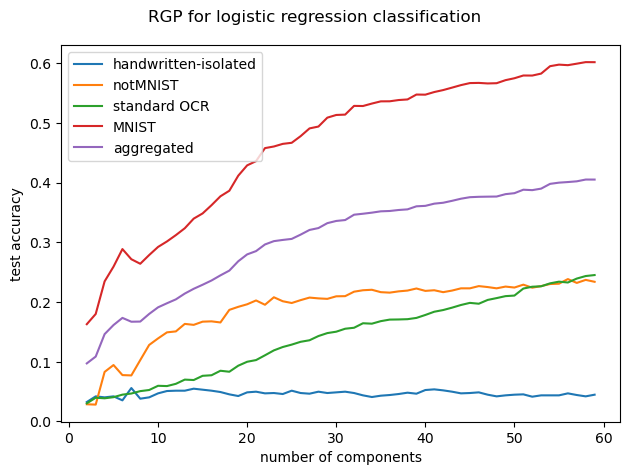

In [167]:
plot_scores(logreg_rgp_results, range(2, 60), title="RGP for logistic regression classification")

### KNN

In [161]:
knn_rgp_results = test_trf_models(create_knn, rgptrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.31482481956481934 sec.

Model testing took: 0.3358190059661865 sec.

handwritten-isolated score: 0.23995535714285715
notMNIST score: 0.05074786324786325
standard OCR score: 0.0369498705577783
MNIST score: 0.1445
Aggregate score: 0.11230730351276219
------
n_components: 3
KNN training took: 0.27251195907592773 sec.

Model testing took: 0.308521032333374 sec.

handwritten-isolated score: 0.27845982142857145
notMNIST score: 0.07238247863247864
standard OCR score: 0.0602494704636385
MNIST score: 0.1669
Aggregate score: 0.1362143037654789
------
n_components: 4
KNN training took: 0.23021268844604492 sec.

Model testing took: 0.348247766494751 sec.

handwritten-isolated score: 0.3510044642857143
notMNIST score: 0.13221153846153846
standard OCR score: 0.10167098140738998
MNIST score: 0.2171
Aggregate score: 0.18837503158958807
------
n_components: 5
KNN training took: 0.22045516967773438 sec.

Model testing took: 0.4429960250854492 sec.

handwritten-isolat

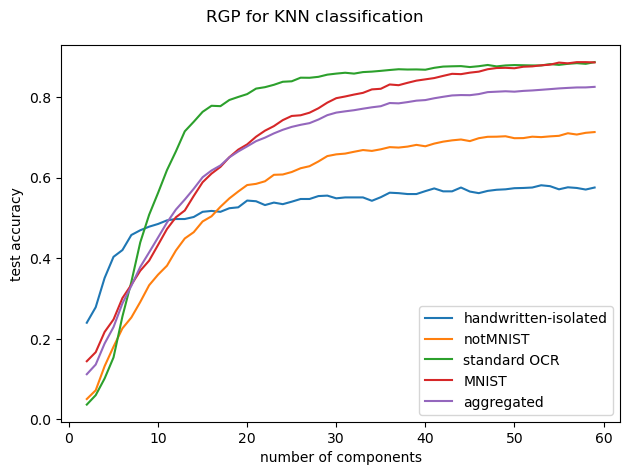

In [166]:
plot_scores(knn_rgp_results, range(2, 60), title="RGP for KNN classification")

## CNN tests

TODO these need to be done a datahub or someones laptop will explode